# Matrix-vector products with BTTB/BCCB matrices

This notebook illustrates algoritmhs for computing the matrix-vector product for the cases in which the matrix is Block Toeplitz formed by Toeplitz Blocks (BTTB) and Block Circulant formed by Circulant Blocks (BCCB).

#### References

* Davis, P. J. (1979). Circulant matrices, John Wiley & Sons Inc, ISBN 0-471-05771-1

* Jain, A. K. (1989), Fundamentals of Digital Image Processing, Prentice Hall, ISBN 978-0-13-336165-0.

* Horn, R. A. and C. R. Johnson, (1991), Topics in Matrix Analysis, Cambridge University Press, ISBN 978-0-521-46713-1.

* Chan, R. H. and X-Q Jin (2007), An introduction to iterative Toeplitz solvers, Philadelphia: Society for Industrial and Applied Mathematics, ISBN 978-0-898716-36-8.

* Magnus, J. R. and H. Neudecker (2007), Matrix differential calculus with applications in statistics and econometrics, 3rd edition, John Wiley & Sons, ISBN 0-471-98632-1.

* Golub, G. H. and C. F. Van Loan, (2013), Matrix computations, 4th edition, Johns Hopkins University Press, ISBN 978-1-4214-0794-4.

## Topics

* [Block Circulant - Circulant Blocks (BCCB) matrices](#sec1)

    * [BCCB are diagonalized by the Kronecker product of Fourier matrices](#sec1a)
    
    * [The eigenvalues of a BCCB matrix can be computed by the 2D Fourier transform](#sec1b)

    * [Product of $\mathbf{C}_{BCCB}$ and an arbitrary vector $\mathbf{a}$](#sec1c)

* [Block Toeplitz - Toeplitz Blocks (BTTB) matrices](#sec2)

    * [Arbitrary BTTB matrices are not diagonalized by the Kronecker product of Fourier matrices](#sec2a)
    
    * [The Fourier approach used for BCCB matrices is not valid for the product of arbitrary BTTB matrices and arbitrary vectors](#sec2b)
    
    * [The Fourier approach used for BCCB matrices is valid for the product of some particular BTTB matrices and some particular vectors](#sec2c)
   
* [Arbitrary BTTB matrices can be embedded into BCCB matrices](#sec3)

    * [Product of an arbitrary BTTB matrix $\mathbf{T}_{BTTB}$ and an arbitrary vector $\mathbf{b}$](#sec3a)

In [1]:
import numpy as np
from numpy.linalg import multi_dot
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz, circulant, dft
from scipy.fft import fft, ifft, fft2, ifft2

<a id='sec1'></a>
## Block Circulant - Circulant Blocks (BCCB) matrices

Let $\mathbf{C}_{BCCB}$ be a BCCB matrix (e.g., Davis, 1979, p. 184; Jain, 1989, p. 28). Such matrices have a $Q \times Q$ circulant block structure formed by $P \times P$ circulant blocks $\mathbf{C}_{q}$, $q = 0, \dots, Q - 1$. For convenience, we represent the elements of a block $\mathbf{C}_{q}$ by $c_{p}^{(q)}$, $p = 0, \dots, P - 1$. The example below illustrates a $\mathbf{C}_{BCCB}$ matrix formed by $Q = 4$ and $P = 3$:

<a id='eq1a'></a>
$$
\mathbf{C}_{BCCB} = \begin{bmatrix}
\mathbf{C}_{0} & \mathbf{C}_{3} & \mathbf{C}_{2} & \mathbf{C}_{1} \\
\mathbf{C}_{1} & \mathbf{C}_{0} & \mathbf{C}_{3} & \mathbf{C}_{2} \\
\mathbf{C}_{2} & \mathbf{C}_{1} & \mathbf{C}_{0} & \mathbf{C}_{3} \\
\mathbf{C}_{3} & \mathbf{C}_{2} & \mathbf{C}_{1} & \mathbf{C}_{0}
\end{bmatrix} \quad , \tag{1a}
$$

where

<a id='eq1b'></a>
$$
\mathbf{C}_{q} = \begin{bmatrix}
c_{0}^{(q)} & c_{2}^{(q)} & c_{1}^{(q)} \\
c_{1}^{(q)} & c_{0}^{(q)} & c_{2}^{(q)} \\
c_{2}^{(q)} & c_{1}^{(q)} & c_{0}^{(q)}
\end{bmatrix} \quad , \quad q = 0, 1, 2, 3 \: . \tag{1b}
$$

In [2]:
Q = 4 # number of blocks along rows/columns
P = 3 # number of rows/columns in each block

In [3]:
# matrix containing the columns of each block
columns = 17*np.random.rand(Q, P) + 3

In [4]:
# create the first column of blocks
column_of_blocks = []
for block_column in columns:
    column_of_blocks.append(circulant(block_column))
column_of_blocks = np.stack(column_of_blocks, axis=0)

In [5]:
# create the BCCB matrix from the first column of blocks
ind_col, ind_row = np.ogrid[0:Q, 0:-Q:-1]
indices = ind_col + ind_row
C_BCCB = np.hstack(np.hstack(column_of_blocks[indices]))

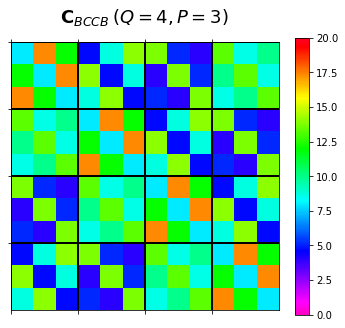

In [6]:
plt.figure(figsize=(6,6))
plt.title('$\mathbf{C}_{BCCB} \: (Q = 4, P = 3)$', fontsize=18)
plt.matshow(C_BCCB, fignum=0, vmin = 0, vmax = 20, cmap='gist_rainbow_r')
plt.colorbar(shrink=0.85)
plt.xticks(ticks=np.arange(Q)*P - 0.5, labels=[])
plt.yticks(ticks=np.arange(Q)*P - 0.5, labels=[])
plt.grid(color='k', linewidth=2)
plt.show()

<a id='sec1a'></a>
### BCCB are diagonalized by the Kronecker product of Fourier matrices

It can be shown that the BCCB matrix $\mathbf{C}_{BCCB}$ (equations [1a](#eq1a) and [1b](#eq1b)) is diagonalized by $\left( \mathbf{F}_{(Q)} \otimes \mathbf{F}_{(P)} \right)$, where $\mathbf{F}_{(Q)}$ and $\mathbf{F}_{(P)}$ are the Fourier matrices of order $Q$ and $P$, respectively. These Fourier matrices are computed with normalization factors $\sqrt{Q}$ and $\sqrt{P}$, so that they are unitary (see the notebook `fourier_1D_4`). It means that $\mathbf{C}_{BCCB}$ satisfies the following equation:

<a id='eq2'></a>
$$
\mathbf{C}_{BCCB} = \left( \mathbf{F}_{(Q)} \otimes \mathbf{F}_{(P)} \right)^{\ast}
\boldsymbol{\Lambda}_{BCCB}
\left( \mathbf{F}_{(Q)} \otimes \mathbf{F}_{(P)} \right) \: , \tag{2}
$$

where $\boldsymbol{\Lambda}_{BCCB}$ is a diagonal matrix containing the eigenvalues of $\mathbf{C}_{BCCB}$ and "$\otimes$" denotes the Kronecker product (Jain, 1989; Horn and Johnson, 1991; the notebook `kronecker-product`).

By properly manipulating [equation 2](#eq2), we obtain (Chan and Jin, 2007):

$$
\begin{split}
\left( \mathbf{F}_{(Q)} \otimes \mathbf{F}_{(P)} \right) \mathbf{C}_{BCCB} &= \boldsymbol{\Lambda}_{BCCB} \, \left( \mathbf{F}_{(Q)} \otimes \mathbf{F}_{(P)} \right) \\
\left( \mathbf{F}_{(Q)} \otimes \mathbf{F}_{(P)} \right) \, \mathbf{C}_{BCCB} \, \mathbf{u}_{0} &= \boldsymbol{\Lambda}_{BCCB} \, \left( \mathbf{F}_{(Q)} \otimes \mathbf{F}_{(P)} \right) \, \mathbf{u}_{0} \\
\left( \mathbf{F}_{(Q)} \otimes \mathbf{F}_{(P)} \right) \, \mathbf{c}_{0} &= \boldsymbol{\Lambda}_{BCCB} \, \frac{1}{\sqrt{QP}}\mathbf{1}_{(QP)}
\end{split} \quad ,
$$

which results in the following equation

<a id='eq3'></a>
$$
\sqrt{QP} \, \left( \mathbf{F}_{(Q)} \otimes \mathbf{F}_{(P)} \right) \, \mathbf{c}_{0} = \boldsymbol{\lambda}_{BCCB} \quad , \tag{3}
$$


where $\mathbf{u}_{0}$ is an $QP \times 1$ vector with the first element equal to $1$ and all the remaining elements equal to $0$, $\mathbf{c}_{0}$ is the first column of $\mathbf{C}_{BTTB}$, $\mathbf{1}_{(QP)}$ is an $QP \times 1$ with all elements equal to $1$ and $\boldsymbol{\lambda}_{BTTB}$ is the vector forming the diagonal of $\boldsymbol{\Lambda}_{BTTB}$ (the eigenvalues of $\mathbf{C}_{BTTB}$).

[Equation 3](#eq3) shows that the eigenvalues of $\mathbf{C}_{BTTB}$ from its first column.

In [7]:
# scale must be sqrt(n) for DFT be unitary
FQ = dft(n=Q, scale='sqrtn')
FP = dft(n=P, scale='sqrtn')

In [8]:
# compute the Kronecker product
FQ_kron_FP = np.kron(FQ, FP)

In [9]:
# compute the eigenvalues of C_BCCB
lambda_BCCB = np.sqrt(Q*P)*np.dot(FQ_kron_FP, C_BCCB[:,0])

In [10]:
# create matrix Lambda_BCCB
Lambda_BCCB = np.diag(lambda_BCCB)

In [11]:
# compute a BCCB matrix C2 by evaluating the right side of equation 2
C2 = multi_dot([np.conj(FQ_kron_FP), Lambda_BCCB, FQ_kron_FP])

In [12]:
# verify that C_BCCB and C2 are equal to each other
np.allclose(C_BCCB, C2)

True

<a id='sec1b'></a>
### The eigenvalues of a BCCB matrix can be computed by the 2D Fourier transform

By using the Kronecker product (see equations 3 and 4 of the notebook `kronecker-product`) and the symmetry of Fourier matrices, [equation 3](#eq3) can be rewritten as follows:

<a id='eq4a'></a>
$$
\sqrt{QP} \; \mathbf{F}_{(Q)} \, \mathbf{G}_{row} \, \mathbf{F}_{(P)} = \mathbf{L}_{row} \: , \tag{4a}
$$

where $\mathbf{G}_{row}$ and $\mathbf{L}_{row}$ are $Q \times P$ matrices obtained, respectively, by reorganizing the vectors $\mathbf{c}_{0}$ and $\boldsymbol{\lambda}_{BCCB}$ along their rows (Jain, 1989; Horn and Johnson, 1991).
Alternatively, [equation 3](#eq3) can be rewritten as follows (see equations 5 and 6 of the notebook `kronecker-product`):

<a id='eq4b'></a>
$$
\sqrt{QP} \; \mathbf{F}_{(P)} \, \mathbf{G}_{col} \, \mathbf{F}_{(Q)} = \mathbf{L}_{col} \: , \tag{4b}
$$

where $\mathbf{G}_{col}$ and $\mathbf{L}_{col}$ are $P \times Q$ matrices obtained, respectively, by reorganizing the vectors $\mathbf{c}_{0}$ and $\boldsymbol{\lambda}_{BCCB}$ along their columns (Magnus and Neudecker, 2007).


Equations [4a](#eq4a) and [4b](#eq4b) show that the eigenvalues of $\mathbf{C}_{BCCB}$ can be computed from the 2D DFT of its first column $\mathbf{c}_{0}$ (see the notebook `fourier_2D`).

In [13]:
L_row = np.reshape(lambda_BCCB, (Q, P))

In [14]:
G_row = np.reshape(C_BCCB[:,0], (Q, P))

In [15]:
np.allclose(np.sqrt(Q*P)*multi_dot([FQ, G_row, FP]), L_row)

True

In [16]:
np.allclose(np.sqrt(Q*P)*fft2(x=G_row, norm='ortho'), L_row)

True

In [17]:
L_col = np.reshape(lambda_BCCB, (Q, P)).T

In [22]:
np.allclose(L_col, L_row.T)

True

In [18]:
G_col = np.reshape(C_BCCB[:,0], (Q, P)).T

In [23]:
np.allclose(G_col, G_row.T)

True

In [19]:
np.allclose(np.sqrt(Q*P)*multi_dot([FP, G_col, FQ]), L_col)

True

In [20]:
np.allclose(np.sqrt(Q*P)*fft2(x=G_col, norm='ortho'), L_col)

True

<a id='sec1c'></a>
### Product of $\mathbf{C}_{BCCB}$ and an arbitrary vector $\mathbf{a}$

Let's consider the following matrix-vector product:

<a id='eq5'></a>
$$
\mathbf{C}_{BCCB} \; \mathbf{a} = \mathbf{w} \: , \tag{5}
$$

where $\mathbf{a}$ and $\mathbf{w}$ are $QP \times 1$ vectors and $\mathbf{C}_{BCCB}$ is an arbitrary $QP \times QP$ BCCB matrix. By using [equation 2](#eq2), we can rewrite [equation 5](#eq5) and obtain 

<a id='eq6'></a>
$$
\left( \mathbf{F}_{(Q)} \otimes \mathbf{F}_{(P)} \right)^{\ast} \boldsymbol{\Lambda}_{BCCB} \left( \mathbf{F}_{(Q)} \otimes \mathbf{F}_{(P)} \right) \mathbf{a} = \mathbf{w} \: . \tag{6}
$$

Remember that $\boldsymbol{\Lambda}_{BCCB}$ is a diagonal matrix with diagonal defined by the vector $\boldsymbol{\lambda}_{BCCB}$ ([equation 3](#eq3)). Consequently, we can rewrite [equation 6](#eq6) according to:

<a id='eq7a'></a>
$$
\left( \mathbf{F}_{(Q)} \otimes \mathbf{F}_{(P)} \right)^{\ast} \mathbf{h}
 = \mathbf{w} \: , \tag{7a}
$$

where $\mathbf{h}$ is a $QP \times 1$ vector given by

<a id='eq7b'></a>
$$
\mathbf{h} = \boldsymbol{\lambda}_{BCCB} \circ \left( \mathbf{F}_{(Q)} \otimes \mathbf{F}_{(P)} \right) \mathbf{a} \tag{7b}
$$

and "$\circ$" denotes the Hadamard product.

By using the Kronecker product (see equations 3 and 4 of the notebook `kronecker-product`), we can transform equations [7a](#eq7a) and [7b](#eq7b) into:

<a id='eq8a'></a>
$$
\mathbf{F}_{(Q)}^{\ast} \, \mathbf{H}_{row} \, \mathbf{F}_{(P)}^{\ast} = \mathbf{W}_{row} \tag{8a}
$$

and

<a id='eq8b'></a>
$$
\mathbf{H}_{row} = \mathbf{L}_{row} \circ \left( \mathbf{F}_{(Q)} \mathbf{A}_{row} \, \mathbf{F}_{(P)} \right) \quad , \tag{8b}
$$

where $\mathbf{H}_{row}$, $\mathbf{W}_{row}$ and $\mathbf{A}_{row}$ are $Q \times P$ matrices obtained by reorganizing, respectively, the vectors $\mathbf{h}$ ([equation 7b](#eq7b)), $\mathbf{a}$ and $\mathbf{w}$ ([equation 5](#eq5)) along their rows and $\mathbf{L}_{row}$ is defined by [equation 4a](#eq4a). By combining equations [8a](#eq8a) and [8b](#eq8b), we obtain 

<a id='eq8c'></a>
$$
\mathbf{F}_{(Q)}^{\ast} \left[ \mathbf{L}_{row} \circ \left( \mathbf{F}_{(Q)} \mathbf{A}_{row} \, \mathbf{F}_{(P)} \right) \right] \mathbf{F}_{(P)}^{\ast} = \mathbf{W}_{row} \: . \tag{8c}
$$

Alternatively, we can transform equations [7a](#eq7a) and [7b](#eq7b) into (see equations 5 and 6 of the notebook `kronecker-product`):

<a id='eq9a'></a>
$$
\mathbf{F}_{(P)}^{\ast} \, \mathbf{H}_{col} \, \mathbf{F}_{(Q)}^{\ast} = \mathbf{W}_{col} \tag{9a}
$$

and

<a id='eq9b'></a>
$$
\mathbf{H}_{col} = \mathbf{L}_{col} \circ \left( \mathbf{F}_{(P)} \mathbf{A}_{col} \, \mathbf{F}_{(Q)} \right) \quad , \tag{9b}
$$

where $\mathbf{H}_{col}$, $\mathbf{W}_{col}$ and $\mathbf{A}_{col}$ are $P \times Q$ matrices obtained by reorganizing, respectively, the vectors $\mathbf{h}$ ([equation 7b](#eq7b)), $\mathbf{a}$ and $\mathbf{w}$ ([equation 5](#eq5)) along their columns and $\mathbf{L}_{col}$ is defined by [equation 4b](#eq4b). By combining equations [9a](#eq9a) and [9b](#eq9b), we obtain 

<a id='eq9c'></a>
$$
\mathbf{F}_{(P)}^{\ast} \left[ \mathbf{L}_{col} \circ \left( \mathbf{F}_{(P)} \mathbf{A}_{col} \, \mathbf{F}_{(Q)} \right) \right] \mathbf{F}_{(Q)}^{\ast} = \mathbf{W}_{col} \: . \tag{9c}
$$

It is worth noting that matrix $\mathbf{W}_{row}$ ([equation 8a](#eq8a)), which contain the elements of vector $\mathbf{w}$ ([equation 5](#eq5)), is the 2D IDFT of the Hadamard product of the matrix $\mathbf{L}_{row}$ ([equation 4a](#eq4a)), which contains the eigenvalues of the BCCB matrix $\mathbf{C}_{BCCB}$ ([equation 5](#eq5)), and the 2D DFT of the matrix $\mathbf{A}_{row}$, which contains the elements of vector $\mathbf{a}$ ([equation 5](#eq5)). Similarly, matrix $\mathbf{W}_{col}$ ([equation 9a](#eq9a)), which contain the elements of vector $\mathbf{w}$ ([equation 5](#eq5)), is the 2D IDFT of the Hadamard product of the matrix $\mathbf{L}_{col}$ ([equation 4b](#eq4b)), which contains the eigenvalues of the BCCB matrix $\mathbf{C}_{BCCB}$ ([equation 5](#eq5)), and the 2D DFT of the matrix $\mathbf{A}_{col}$, which contains the elements of vector $\mathbf{a}$ ([equation 5](#eq5)). Equations [8c](#eq8c) and [9c](#eq9c) show that the matrix-vector product of a BCCB matrix and an arbitrary vector can be computed by using the 2D DFT.

In [24]:
# create an arbitrary vector a
a = np.random.rand(Q*P)

In [25]:
# compute a vector w by using equation 5
w = np.dot(C_BCCB, a)

In [26]:
# reorganize w along the lines of a Q x P matrix W
W_row = np.reshape(w, (Q, P))

In [27]:
# reorganize a along the lines of a Q x P matrix A
A_row = np.reshape(a, (Q, P))

In [28]:
# compute matrix H by using equation 8b
H_row = L_row*fft2(x=A_row, norm='ortho')

In [29]:
# compute a matrix W2 by using equation 8a
W_row2 = ifft2(x=H_row, norm='ortho')

In [30]:
# compare matrices W and W2
np.allclose(W_row, W_row2)

True

In [31]:
# reorganize w along the columns of a P x Q matrix W
W_col = np.reshape(w, (Q, P)).T

In [32]:
# reorganize a along the lines of a P x Q matrix A
A_col = np.reshape(a, (Q, P)).T

In [33]:
# compute matrix H by using equation 9b
H_col = L_col*fft2(x=A_col, norm='ortho')

In [34]:
# compute a matrix W2 by using equation 9a
W_col2 = ifft2(x=H_col, norm='ortho')

In [35]:
# compare matrices W and W2
np.allclose(W_col, W_col2)

True

In [36]:
np.allclose(W_col, W_row.T)

True

<a id='sec2'></a>
## Block Toeplitz - Toeplitz Block (BTTB) matrices

Let $\mathbf{T}_{BTTB}$ be a BTTB matrix (e.g., Jain, 1989, p. 28; Chan and Jin, 2007, p. 67). Such matrices have a $Q \times Q$ Toeplitz block structure formed by $P \times P$ Toeplitz blocks $\mathbf{T}_{q}$, $q = -Q + 1, \dots, Q - 1$. For convenience, we represent the elements of a block $\mathbf{T}_{q}$ by $t_{p}^{(q)}$, $p = -P + 1, \dots, P - 1$. The example below illustrates a $\mathbf{T}_{BTTB}$ matrix formed by $Q = 4$ and $P = 3$:

<a id='eq10a'></a>
$$
\mathbf{T}_{BTTB} = \begin{bmatrix}
\mathbf{T}_{0} & \mathbf{T}_{1} & \mathbf{T}_{2} & \mathbf{T}_{3} \\
\mathbf{T}_{-1} & \mathbf{T}_{0} & \mathbf{T}_{1} & \mathbf{T}_{2} \\
\mathbf{T}_{-2} & \mathbf{T}_{-1} & \mathbf{T}_{0} & \mathbf{T}_{1} \\
\mathbf{T}_{-3} & \mathbf{T}_{-2} & \mathbf{T}_{-1} & \mathbf{T}_{0}
\end{bmatrix} \quad , \tag{10a}
$$

where

<a id='eq10b'></a>
$$
\mathbf{T}_{q} = \begin{bmatrix}
t_{0}^{(q)} & t_{2}^{(q)} & t_{1}^{(q)} \\
t_{-1}^{(q)} & t_{0}^{(q)} & t_{2}^{(q)} \\
t_{-2}^{(q)} & t_{-1}^{(q)} & t_{0}^{(q)}
\end{bmatrix} \quad , \quad q = -3, \dots, 3 \: . \tag{10b}
$$

In [37]:
Q = 4 # number of blocks along rows/columns
P = 3 # number of rows/columns in each block

In [38]:
# matrix containing the columns of each block
columns = 17*np.random.rand(2*Q -1, P) + 3
rows = 17*np.random.rand(2*Q - 1, P) + 3

In [39]:
# create a list of blocks 
list_of_blocks = []
for block_column, block_row in zip(columns, rows):
    list_of_blocks.append(toeplitz(block_column, block_row))
list_of_blocks = np.stack(list_of_blocks, axis=0)

In [40]:
# create the BCCB matrix from the list of blocks
ind_col, ind_row = np.ogrid[0:Q, Q-1:-1:-1]
indices = ind_col + ind_row
T_BTTB = np.hstack(np.hstack(list_of_blocks[indices]))

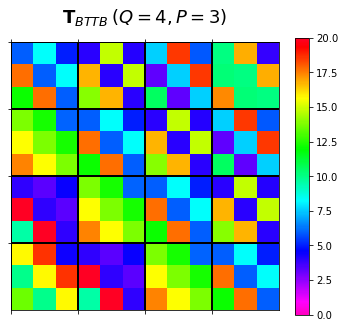

In [41]:
plt.figure(figsize=(6,6))
plt.title('$\mathbf{T}_{BTTB} \: (Q = 4, P = 3)$', fontsize=18)
plt.matshow(T_BTTB, fignum=0, vmin = 0, vmax = 20, cmap='gist_rainbow_r')
plt.colorbar(shrink=0.85)
plt.xticks(ticks=np.arange(Q)*P - 0.5, labels=[])
plt.yticks(ticks=np.arange(Q)*P - 0.5, labels=[])
plt.grid(color='k', linewidth=2)
plt.show()

<a id='sec2a'></a>
### Arbitrary BTTB matrices are not diagonalized by the Kronecker product of Fourier matrices

Differently from BCCB matrices (equation [1a](#eq1a) and [1b](#eq1b)), arbitrary BTTB matrices $\mathbf{T}_{BTTB}$ are not diagonalized by the matrix $\left( \mathbf{F}_{(Q)} \otimes \mathbf{F}_{(P)} \right)$. It means that we cannot write an [equation 2](#eq2) for the BTTB matrix $\mathbf{T}_{BTTB}$, in which the elements of a diagonal matrix $\boldsymbol{\Lambda}_{BTTB}$ are obtained by computing the Fourier transform of the first column of $\mathbf{T}_{BTTB}$, according to equations [3](#eq3), [4a](#eq4a) or [4b](#eq4b). In order to illustrate this issue, consider the matrix $\mathbf{T}_{BTTB}^{\prime}$ given by:

<a id='eq11'></a>
$$
\mathbf{T}_{BTTB}^{\prime} = \left( \mathbf{F}_{(Q)} \otimes \mathbf{F}_{(P)} \right)^{\ast} \, \boldsymbol{\Lambda}_{BTTB}^{\prime} \, \left( \mathbf{F}_{(Q)} \otimes \mathbf{F}_{(P)} \right) \: , \tag{11}
$$

where $\boldsymbol{\Lambda}_{BTTB}^{\prime}$ is a diagonal matrix. Besides, consider that the diagonal of $\boldsymbol{\Lambda}_{BTTB}^{\prime}$ is defined by the vector $\boldsymbol{\lambda}_{BTTB}^{\prime}$:

<a id='eq12'></a>
$$
\boldsymbol{\lambda}_{BTTB}^{\prime} = \sqrt{QP} \, \left( \mathbf{F}_{(Q)} \otimes \mathbf{F}_{(P)} \right) \, \mathbf{t}_{0} \quad , \tag{12}
$$

where $\mathbf{t}_{0}$ is the first column of the $QP \times QP$ BTTB matrix $\mathbf{T}_{BTTB}$. The cells below show that matrix $\mathbf{T}_{BTTB}^{\prime}$ is different from the BTTB matrix $\mathbf{T}_{BTTB}$.

In [42]:
# scale must be sqrt(n) for DFT be unitary
FQ = dft(n=Q, scale='sqrtn')
FP = dft(n=P, scale='sqrtn')

In [43]:
# compute the Kronecker product
FQ_kron_FP = np.kron(FQ, FP)

In [44]:
# compute the eigenvalues of lambda_BTTB_prime (equation 12)
lambda_BTTB_prime = np.sqrt(Q*P)*np.dot(FQ_kron_FP, T_BTTB[:,0])

In [45]:
# create matrix Lambda_BTTB_prime (equation 11)
Lambda_BTTB_prime = np.diag(lambda_BTTB_prime)

In [46]:
# compute the matrix T_BTTB_prime according to equation 11
T_BTTB_prime = multi_dot([np.conj(FQ_kron_FP), Lambda_BTTB_prime, FQ_kron_FP]).real

In [47]:
# verify that T_BTTB and T_BTTB_prime are equal to each other
np.allclose(T_BTTB, T_BTTB_prime)

False

The cell above shows that $\mathbf{T}_{BTTB} \ne \mathbf{T}_{BTTB}^{\prime}$.

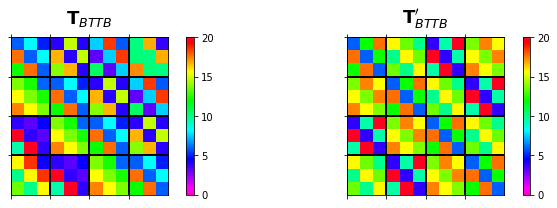

In [48]:
plt.close('all')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,3))

plt.subplot(121)
plt.title('$\mathbf{T}_{BTTB}$', fontsize=18)
plt.matshow(T_BTTB, fignum=False, vmin = 0, vmax = 20, cmap='gist_rainbow_r')
plt.colorbar()
plt.xticks(ticks=np.arange(Q)*P - 0.5, labels=[])
plt.yticks(ticks=np.arange(Q)*P - 0.5, labels=[])
plt.grid(color='k', linewidth=2)

plt.subplot(122)
plt.title('$\mathbf{T}_{BTTB}^{\prime}$', fontsize=18)
plt.matshow(T_BTTB_prime, fignum=False, vmin = 0, vmax = 20, cmap='gist_rainbow_r')
plt.colorbar()
plt.xticks(ticks=np.arange(Q)*P - 0.5, labels=[])
plt.yticks(ticks=np.arange(Q)*P - 0.5, labels=[])
plt.grid(color='k', linewidth=2)

plt.tight_layout()

plt.show()

<a id='sec2b'></a>
### The Fourier approch used for BCCB matrices is not valid for the product of arbitrary BTTB matrices and arbitrary vectors

The cells above show that, for arbitrary BTTB matrices $\mathbf{T}_{BTTB}$ and vectors $\mathbf{a}$, 

$$
\mathbf{T}_{BTTB} \, \mathbf{a} \ne \mathbf{T}_{BTTB}^{\prime} \, \mathbf{a} \: ,
$$

where $\mathbf{T}_{BTTB}^{\prime}$ is defined by equations [11](#eq11) and [12](#eq12). This implies that, for arbitrary BTTB matrices $\mathbf{T}_{BTTB}$ and vectors $\mathbf{a}$, we cannot compute the product $\mathbf{T}_{BTTB} \, \mathbf{a}$ via 2D Fourier transform by using the same approach for BCCB matrices (equations [5](#eq5)-[9](#eq9)).

In [49]:
# create a vector a
a = np.random.rand(Q*P)

In [50]:
# product of T_BTTB and this vector a
T_BTTB_a = np.dot(T_BTTB, a)

In [51]:
# product of T_BTTB' and vector a
T_BTTB_prime_a = np.dot(T_BTTB_prime, a)

In [52]:
# notice that they are not the same
np.allclose(T_BTTB_a, T_BTTB_prime_a)

False

<a id='sec2c'></a>
### The Fourier approch used for BCCB matrices is valid for the product of some particular BTTB matrices and some particular vectors

For some particular BTTB matrices $\mathbf{T}_{BTTB}$ and some particular vectors $\mathbf{a}$, the same approach defined by equations [5](#eq5)-[9](#eq9) for BCCB matrices can be used to compute the product $\mathbf{T}_{BTTB} \, \mathbf{a}$. 

These particular BTTB matrices $\mathbf{T}_{BTTB}$ and vectors $\mathbf{a}$ must satisfy the following conditions:

* Matrix $\mathbf{T}_{BTTB}$ must be block lower triangular;
* All blocks $\mathbf{T}_{q}$ must be lower triangular;
* The last $Q-Q_{1}$ blocks $\mathbf{T}_{q}$ (with $Q_{1} < Q$) in the first block column must be formed by null elements;
* The last $P-P_{1}$ elements of $\mathbf{t}^{(q)}_{0} \equiv \mathbf{T}_{q}[: \, , \, 0]$ (with $P_{1} < P$) of each block must be equal to zero;
* Vector $\mathbf{a}$ must be formed by stacking $Q$ $P \times 1$ vectors $\mathbf{a}_{q}$;
* The last $Q_{1}$ vectors $\mathbf{a}_{q}$ (with $Q_{1} < Q$) must be formed by null elements;
* The last $P_{1}$ elements (with $P_{1} < P$) of all vectors $\mathbf{a}_{q}$ must be equal to zero.

If $\mathbf{T}_{BTTB}$ and $\mathbf{a}$ satisfy the above conditions, the matrix $\mathbf{T}_{BTTB}^{\prime}$ satisfies the following conditions:

* $\mathbf{T}_{BTTB}^{\prime} \ne \mathbf{T}_{BTTB}$;
* $\mathbf{T}_{BTTB}^{\prime} \, \mathbf{a} = \mathbf{T}_{BTTB} \, \mathbf{a}$  .

In [53]:
Q = 7 # number of blocks along rows/columns
P = 5 # number of rows/columns in each block

In [54]:
Q1 = 3 
P1 = 3

In [55]:
# matrices containing the columns/rows of each block
columns = 17*np.random.rand(2*Q -1, P) + 3
columns[:Q-1] = 0 # fill the row blocks with zeros
columns[Q-1 + Q1:] = 0 # 
for i in range(Q-1, Q-1 + Q1):
    columns[i][P1:] = 0
rows = np.zeros((2*Q - 1, P))

In [56]:
# create a list of blocks 
list_of_blocks = []
for block_column, block_row in zip(columns, rows):
    list_of_blocks.append(toeplitz(block_column, block_row))
list_of_blocks = np.stack(list_of_blocks, axis=0)

In [57]:
# create the BTTB matrix from the list of blocks
ind_col, ind_row = np.ogrid[0:Q, Q-1:-1:-1]
indices = ind_col + ind_row
T_BTTB = np.hstack(np.hstack(list_of_blocks[indices]))

In [58]:
# vector a satisfying the conditions above
a = []
for i in range(Q - Q1):
    a.append(np.hstack([17*np.random.rand(P-P1) + 3, np.zeros(P1)]))
for i in range(Q1):
    a.append(np.zeros(P))
a = np.hstack(a)

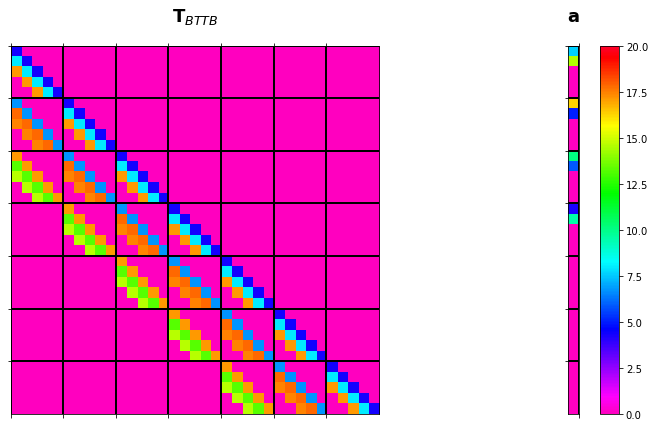

In [59]:
plt.figure(figsize=(10, 6))

plt.subplot(1,2,1)
plt.title('$\mathbf{T}_{BTTB}$', fontsize=18)
plt.matshow(T_BTTB, fignum=0, vmin = 0, vmax = 20, cmap='gist_rainbow_r')
plt.xticks(ticks=np.arange(Q)*P - 0.5, labels=[])
plt.yticks(ticks=np.arange(Q)*P - 0.5, labels=[])
plt.grid(color='k', linewidth=2)

plt.subplot(1,2,2)
plt.title('$\mathbf{a}$', fontsize=18)
plt.matshow(np.reshape(a, (a.size,1)), fignum=0, vmin = 0, vmax = 20, cmap='gist_rainbow_r')
plt.colorbar()
plt.xticks(ticks=[0.5], labels=[])
plt.yticks(ticks=np.arange(Q)*P - 0.5, labels=[])
plt.grid(color='k', linewidth=2)

plt.tight_layout()

plt.show()

In [60]:
# scale must be sqrt(n) for DFT be unitary
FQ = dft(n=Q, scale='sqrtn')
FP = dft(n=P, scale='sqrtn')

In [61]:
# compute the Kronecker product
FQ_kron_FP = np.kron(FQ, FP)

In [62]:
# compute the eigenvalues of lambda_BTTB_prime (equation 12)
lambda_BTTB_prime = np.sqrt(Q*P)*np.dot(FQ_kron_FP, T_BTTB[:,0])

In [63]:
# create matrix Lambda_BTTB_prime (equation 11)
Lambda_BTTB_prime = np.diag(lambda_BTTB_prime)

In [64]:
# compute the matrix T_BTTB_prime according to equation 11
T_BTTB_prime = multi_dot([np.conj(FQ_kron_FP), Lambda_BTTB_prime, FQ_kron_FP]).real

In [65]:
# verify that T_BTTB and T_BTTB_prime are equal to each other
np.allclose(T_BTTB, T_BTTB_prime)

False

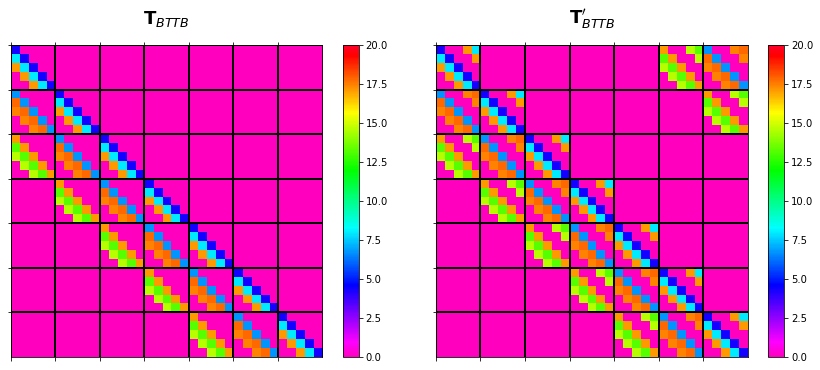

In [66]:
plt.close('all')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

plt.subplot(121)
plt.title('$\mathbf{T}_{BTTB}$', fontsize=18)
plt.matshow(T_BTTB, fignum=False, vmin = 0, vmax = 20, cmap='gist_rainbow_r')
plt.colorbar()
plt.xticks(ticks=np.arange(Q)*P - 0.5, labels=[])
plt.yticks(ticks=np.arange(Q)*P - 0.5, labels=[])
plt.grid(color='k', linewidth=2)

plt.subplot(122)
plt.title('$\mathbf{T}_{BTTB}^{\prime}$', fontsize=18)
plt.matshow(T_BTTB_prime, fignum=False, vmin = 0, vmax = 20, cmap='gist_rainbow_r')
plt.colorbar()
plt.xticks(ticks=np.arange(Q)*P - 0.5, labels=[])
plt.yticks(ticks=np.arange(Q)*P - 0.5, labels=[])
plt.grid(color='k', linewidth=2)

plt.tight_layout()

plt.show()

The differences between $\mathbf{T}_{BTTB}$ and $\mathbf{T}_{BTTB}^{\prime}$ are concentrated at the blocks located at the upper right corner and at the upper right corner of each non-null block. The remaining parts of these matrices are equal to each other. These differences, however, coincide with the null elements of $\mathbf{a}$. As a consequence:

$$
\mathbf{T}_{BTTB} \, \mathbf{a} = \mathbf{T}_{BTTB}^{\prime} \, \mathbf{a} \: .
$$

In [67]:
# product of T_BTTB and this vector a
w = np.dot(T_BTTB, a)

In [68]:
# product of T_BTTB' and vector a
w2 = np.dot(T_BTTB_prime, a)

In [69]:
# notice that they are not the same
np.allclose(w, w2)

True

In this case, we can also use the approach defined by equations [5](#eq5)-[9](#eq9) to compute the product $\mathbf{T}_{BTTB} \, \mathbf{a}$ involving the particular BTTB matrix $\mathbf{T}_{BTTB}$ and vector $\mathbf{a}$:

In [70]:
# reorganize w along the lines of a Q x P matrix W
W = np.reshape(w, (Q, P))

In [71]:
# reorganize lambda_BTTB_prime along the lines of a Q x P matrix L
L = np.reshape(lambda_BTTB_prime, (Q, P))

In [72]:
# reorganize a along the lines of a Q x P matrix A
A = np.reshape(a, (Q, P))

In [73]:
# compute matrix H by using equation 8b
H = L*fft2(x=A, norm='ortho')

In [74]:
# compute a matrix W2 by using equation 8a
W2 = ifft2(x=H, norm='ortho')

In [75]:
# compare matrices W and W2
np.allclose(W, W2)

True

<a id='sec3'></a>
## Arbitrary BTTB matrices can be embedded into BCCB matrices

In [ ]:
PAREI AQUI

<a id='sec3a'></a>
### Product of an arbitrary BTTB matrix $\mathbf{T}$ and an arbitrary vector $\mathbf{b}$

Let's consider the product

$$
\mathbf{T} \mathbf{v} = \mathbf{w} \: ,
$$

where $\mathbf{T}$ is a BTTB matrix given by

$$
\mathbf{T} = \begin{bmatrix}
\mathbf{T}_{1} & \cdots & \mathbf{T}_{M} \\
\vdots & \ddots & \vdots \\
\mathbf{T}_{-M} & \cdots & \mathbf{T}_{1}
\end{bmatrix} \: ,
$$
where $\mathbf{T}_{\ell}$, $\ell = -M, \dots, 1, \dots, M$, are $N \times N$ Toeplitz matrices whose $ij$-th element is represented by $t^{\ell}_{ij}$ and the vectors $\mathbf{v}$ and $\mathbf{w}$ are conveninetly defined as follows:

$$
\mathbf{v} = \begin{bmatrix}
\mathbf{v}_{1} \\
\mathbf{v}_{2} \\
\vdots \\
\mathbf{v}_{M}
\end{bmatrix}
$$

and

$$
\mathbf{w} = \begin{bmatrix}
\mathbf{w}_{1} \\
\mathbf{w}_{2} \\
\vdots \\
\mathbf{w}_{M}
\end{bmatrix} \: ,
$$

where $\mathbf{v}_{\ell}$ and $\mathbf{w}_{\ell}$, $\ell = 1, \dots, M$, are $N \times 1$ vectors.

In order to compute the matrix-vetor product $\mathbf{T} \mathbf{v}$ efficiently, let's transform it in the auxiliary matrix-vector product

$$
\mathbf{C} \mathbf{p} = \mathbf{q} \: ,
$$

where $\mathbf{p}$ and $\mathbf{q}$ are $4MN \times 1$ vectors and $\mathbf{C}$ is a $4MN \times 4MN$ Block Circulant formed by Circulant Blocks (BCCB) matrix. 


Matrix $\mathbf{C}$ is formed by a grid of $2M \times 2M$ blocks, where each block is a $2N \times 2N$ matrix. The first column of blocks forming the BCCB matrix $\mathbf{C}$ is given by:

$$
\left[\mathbf{C} \right]_{(1)} = \begin{bmatrix}
\mathbf{C}_{1} \\
\mathbf{C}_{2} \\
\vdots \\
\mathbf{C}_{M-1} \\
\mathbf{C}_{M} \\
\mathbf{0} \\
\mathbf{C}_{M} \\
\mathbf{C}_{M-1} \\
\vdots \\
\mathbf{C}_{3} \\
\mathbf{C}_{2}
\end{bmatrix}
$$

and its remaining columns of blocks are obtained by properly down-shifting the blocks of $\left[\mathbf{C} \right]_{(1)}$ (Golub and Van Loan, 2013). Each block $\mathbf{C}_{\ell}$, $\ell = 1, \dots, M$, is a $2N \times 2N$ circulant matrix and $\mathbf{0}$ is a $2N \times 2N$ matrix with all elements equal to zero. The first column of the circulant matrix $\mathbf{C}_{\ell}$ is given by:

$$
\left[\mathbf{C}_{\ell} \right]_{(1)} = \begin{bmatrix}
t^{\ell}_{11} \\
t^{\ell}_{21} \\
\vdots \\
t^{\ell}_{(M-1)1} \\
t^{\ell}_{M1} \\
0 \\
t^{\ell}_{M1} \\
t^{\ell}_{(M-1)1} \\
\vdots \\
t^{\ell}_{31} \\
t^{\ell}_{21}
\end{bmatrix}
$$

and its remaining columns are generated by properly down-shifting the elements of $\left[\mathbf{C}_{\ell} \right]_{(1)}$ (Golub and Van Loan, 2013).

The $4MN \times 1$ vectors $\mathbf{p}$ and $\mathbf{q}$ are given by:

$$
\mathbf{p} = \begin{bmatrix}
\mathbf{p}_{1} \\
\mathbf{p}_{2} \\
\vdots \\
\mathbf{p}_{M} \\
\mathbf{0}_{(2MN)}
\end{bmatrix}
$$

and

$$
\mathbf{q} = \begin{bmatrix}
\mathbf{q}_{1} \\
\mathbf{q}_{2} \\
\vdots \\
\mathbf{q}_{M} \\
\mathbf{0}_{(2MN)}
\end{bmatrix} \: ,
$$

where $\mathbf{0}_{(2MN)}$ is a $2MN \times 1$ vetor of zeros,

$$
\mathbf{p}_{\ell} = \begin{bmatrix}
\mathbf{v}_{\ell} \\
\mathbf{0}_{(N)}
\end{bmatrix} \: ,
$$

$$
\mathbf{q}_{\ell} = \begin{bmatrix}
\mathbf{w}_{\ell} \\
\mathbf{0}_{(N)}
\end{bmatrix}
$$

and $\mathbf{0}_{(N)}$ is a $N \times 1$ vetor of zeros.

By using the Kronecker product properties, the auxiliary matrix-vetor product can be rewritten as follows:

$$
\mathbf{F}_{(2M)}^{\ast} \left[ \mathbf{L} \circ \left( \mathbf{F}_{(2M)} \mathbf{P} \, \mathbf{F}_{(2N)} \right) \right] \mathbf{F}_{(2N)}^{\ast} = \mathbf{Q} \: ,
$$

where "$\circ$" denotes the [**Hadamard product**](https://en.wikipedia.org/wiki/Hadamard_product_(matrices)), $\mathbf{L}$ is a $2M \times 2N$ row-oriented matrix containing the eigenvalues of $\mathbf{C}_{(BCCB)}$, and $\mathbf{P}$ and $\mathbf{Q}$ are $2M \times 2N$ row-oriented matrices obtained from the vectors $\mathbf{p}$ and $\mathbf{q}$.

The algoritmh for computing the matrix-vector product $\mathbf{T}\mathbf{v}$ and obtaining the resulting vector $\mathbf{w}$ can be summarized in the following steps:

1. Compute the first column of the embedding $4MN \times 4MN$ BCCB matrix $\mathbf{C}$ by using the first column of the $MN \times MN$ BTTB matrix $\mathbf{T}$;
2. Compute the eigenvalues of $\mathbf{C}$ and rearrange them in rows of the $2M \times 2N$ matrix $\mathbf{L}$;
3. Rearrange the vector $\mathbf{p}$ in the rows of the $2M \times 2N$ matrix $\mathbf{P}$;
4. Compute the Hadammard product $\mathbf{L} \circ \tilde{\mathbf{P}}$, where $\tilde{\mathbf{P}} = \mathbf{F}_{(2M)} \mathbf{P} \, \mathbf{F}_{(2N)}$ is computed by using a fast algorithm for 2D DFT;
5. Compute the resulting $2M \times 2N$ matrix $\mathbf{Q} = \mathbf{F}_{(2M)}^{\ast} \left[ \mathbf{L} \circ \tilde{\mathbf{P}}\right] \mathbf{F}_{(2N)}^{\ast}$ by using a fast algorithm for inverse 2D DFT;
6. Rearrange the rows of $\mathbf{Q}$ to obtain the vector $\mathbf{q}$;
7. Rearrange the elements of $\mathbf{q}$ to obtain the vector $\mathbf{w}$.

In [ ]:
N = 7 # order of each block
M = 7 # number of blocks along the row

v = np.random.rand(M*N)

In [ ]:
extended_v = []
for vl in np.split(v, M):
    extended_v.append(np.hstack([vl, np.zeros(N)]))
extended_v = np.hstack(extended_v)
extended_v = np.hstack([extended_v, np.zeros(2*M*N)])

matrix_V = np.reshape(extended_v, (2*M, 2*N))

In [ ]:
columns = 17*np.random.rand(2*M -1, N) + 3
rows = 17*np.random.rand(2*M -1, N-1) + 3

In [ ]:
columns[3:,:] = 0

In [ ]:
rows[3:,:] = 0

In [ ]:
plt.close('all')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

im = ax.imshow(matrix_V, cmap='gist_rainbow_r',
               vmin=np.min(matrix_V), vmax=np.max(matrix_V))
fig.colorbar(im, ax=ax, orientation='horizontal')
ax.set_title('Matrix V')
ax.set_xticklabels('')
ax.set_yticklabels('')

plt.tight_layout()

plt.show()

In [ ]:
cases = ['SBTSTB', 'BTSTB', 'SBTTB', 'BTTB']

T = [ts.general_BTTB(M, columns[:M]),
     ts.general_BTTB(M, columns),
     ts.general_BTTB(M, columns[:M], rows[:M]),
     ts.general_BTTB(M, columns, rows)]

C = [ts.BCCB_from_BTTB(M, columns[:M]),
     ts.BCCB_from_BTTB(M, columns),
     ts.BCCB_from_BTTB(M, columns[:M], rows[:M]),
     ts.BCCB_from_BTTB(M, columns, rows)]

L = []
for Ci in C:
    # compute the eigenvalues of BCCB
    L.append(ts.eigenvalues_BCCB(2*M, Ci[:,0]))

w = []
for Ti in T:
    w.append(np.dot(Ti, v))

In [ ]:
matrix_W = []
for wi in w:
    Wi = np.block([[wi.reshape(M,N), np.zeros((M,N))],
                   [np.zeros((M,N)), np.zeros((M,N))]])
    matrix_W.append(Wi)

In [ ]:
matrix_W2 = []
for Li in L:
    matrix_W2.append(ifft2(Li*fft2(matrix_V)))

In [ ]:
for Wi, W2i in zip(matrix_W, matrix_W2):
    aae(Wi[:M,:N], W2i[:M,:N])

In [ ]:
plt.close('all')

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 8),
                        subplot_kw={'xticks': [-0.5 + i*N for i in range(2*N)], 
                                    'yticks': [-0.5 + i*M for i in range(2*M)]})

fig.subplots_adjust(left=0.03, right=0.97, hspace=0.3, wspace=0.5)

for ax, case, W2i in zip(axs.flat, cases, matrix_W2):
    im = ax.imshow(W2i.real, cmap='gist_rainbow_r',
                   vmin=np.min(W2i.real), vmax=np.max(W2i.real))
    fig.colorbar(im, ax=ax, orientation='horizontal')
    ax.set_title(case)
    ax.grid(color='k', linestyle='-', linewidth=3)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

plt.tight_layout()
plt.show()

In [ ]:
plt.close('all')

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(10, 18),
                        subplot_kw={'xticks': [-0.5 + i*N for i in range(2*N)], 
                                    'yticks': [-0.5 + i*M for i in range(2*M)]})

fig.subplots_adjust(left=0.03, right=0.97, hspace=0.3, wspace=0.5)

for ax, case, Wi, W2i in zip(axs, cases, matrix_W, matrix_W2):
    im = ax[0].imshow(Wi.real, cmap='gist_rainbow_r',
                      vmin=np.min(Wi.real), vmax=np.max(Wi.real))
    fig.colorbar(im, ax=ax[0], orientation='horizontal')
    ax[0].set_title('True '+case)
    ax[0].grid(color='k', linestyle='-', linewidth=3)
    ax[0].set_xticklabels('')
    ax[0].set_yticklabels('')
    
    im = ax[1].imshow(W2i.real, cmap='gist_rainbow_r',
                      vmin=np.min(W2i.real), vmax=np.max(W2i.real))
    fig.colorbar(im, ax=ax[1], orientation='horizontal')
    ax[1].set_title('Computed '+case)
    ax[1].grid(color='k', linestyle='-', linewidth=3)
    ax[1].set_xticklabels('')
    ax[1].set_yticklabels('')

plt.tight_layout()
plt.show()

In [ ]:
w2 = [ts.BTTB_matrix_vector(M, columns_blocks=columns[:M], v=v),
      ts.BTTB_matrix_vector(M, columns_blocks=columns, v=v),
      ts.BTTB_matrix_vector(M, columns_blocks=columns[:M], rows_blocks=rows[:M], v=v),
      ts.BTTB_matrix_vector(M, columns_blocks=columns, rows_blocks=rows, v=v)]

In [ ]:
for wi, w2i in zip(w, w2):
    aae(wi, w2i)